# ML per previsione di dati immobiliari

## Dipendenze

In [1]:
# dipendenze
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer #per applicare le trasformazioni alle colonne
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler #per normalizzare i dati
from sklearn.preprocessing import LabelEncoder #per trasformare le variabili categoriche in numeriche

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_score, KFold

## Data Preprocessing

In [2]:
CSV = "https://raw.githubusercontent.com/ProfAI/machine-learning-fondamenti/main/datasets/housing_dirty.csv"

df = pd.read_csv(CSV, index_col=0)


In [3]:
x_names = df.columns.drop("PRICE")

y_name = "PRICE"

In [4]:
#Verifica tipologia di dati

for column in df.columns:
    if(df[column].dtype == "object"):
        print(df[column].value_counts())

CRIM
HIGH         130
LOW          127
VERY HIGH    127
MODERATE     122
Name: count, dtype: int64
CHAS
NO     471
YES     35
Name: count, dtype: int64


In [5]:
#Verifica dati mancanti

df.isna().sum()

CRIM         0
ZN           2
INDUS        3
CHAS         0
NOX          7
RM           5
AGE          4
DIS          5
RAD          3
TAX          2
PTRATIO      5
B            3
LSTAT      199
PRICE        4
dtype: int64

In [6]:
# Rimozione valori mancanti nella colonna target

df = df.dropna(subset=y_name)

Rimozione di colonne e righe con valori mancanti > 50%

In [7]:
# Rimozione di righe/colonne con troppi valori mancanti (Threshold > 50%)

df = df.dropna(axis=1, thresh=df.shape[0]*0.5)

df = df.dropna(thresh=df.shape[1]*0.5)

df.isna().sum()

CRIM         0
ZN           2
INDUS        3
CHAS         0
NOX          7
RM           4
AGE          3
DIS          4
RAD          2
TAX          1
PTRATIO      4
B            2
LSTAT      197
PRICE        0
dtype: int64

## Definizione delle pipelines di trasformazione

In [8]:
# Verifica se ci sono colonne con valori nulli e sostituisci i valori nulli con la moda o la media

def replace_nulls(df):
    for column in df.columns: 
        if(column == y_name):
            continue
        if df[column].dtype == "object": #verifica tipo di dato
            replace_with = df[column].mode()[0]
            df[column] = df[column].fillna(replace_with)
        else:
            replace_with = round(df[column].mean(), 1) #arrotondamento scelto in base ad altri valori del dataset
            df[column] = df[column].fillna(replace_with)

In [9]:
# Split tra features numeriche e categoriche

def split_features(df):
    ## Manual
    if("CHAS" in df.columns and "CRIM" in df.columns):
        categorical_ordinal_columns = ["CRIM"] # su cui eseguire LabelEncoding .map()
        categorical_nominal_columns = ["CHAS"] # su cui eseguire OneHotEncoding pd.get_dummies()
    else:
        categorical_ordinal_columns = []
        categorical_nominal_columns = []

    numerical_columns = [col for col in df.columns if df[col].dtype in ["int64", "float64"]]

    if(y_name in numerical_columns):
        numerical_columns.remove(y_name)

    return categorical_ordinal_columns, categorical_nominal_columns, numerical_columns

categorical_ordinal_columns, categorical_nominal_columns, numerical_columns = split_features(df)

print(categorical_ordinal_columns, categorical_nominal_columns, numerical_columns)

['CRIM'] ['CHAS'] ['ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [10]:
# Label Encoding

def label_encoding(df, columns, map):
    for column in columns:
        df[column] = df[column].map(map)

In [11]:
def scale_data(df):
    df = (df - df.mean()) / df.std()
    return df

In [12]:
def one_hot_encoding(df):
    for column in df.columns:
        df = pd.get_dummies(df, columns=[column])
        return df

In [13]:
# Trasformazione dei dati

def transform_data(df):

    replace_nulls(df)

    categorical_ordinal_columns, categorical_nominal_columns, numerical_columns = split_features(df)

    label_encoding(df, categorical_ordinal_columns, {"LOW":0, "MODERATE":1, "HIGH":2, "VERY HIGH":3})

    df = pd.concat([df, one_hot_encoding(df[categorical_nominal_columns])], axis=1).drop(categorical_nominal_columns, axis=1)

    df[numerical_columns] = scale_data(df[numerical_columns])

    df[categorical_ordinal_columns] = scale_data(df[categorical_ordinal_columns])

    return df

In [14]:
# Feature and target split

X = df.drop(y_name, axis=1)
Y = df[y_name]

X = transform_data(X)

In [15]:
# #Train test split

# X_train, X_test, Y_train, Y_test = train_test_split(df.drop(y_name, axis=1), df[y_name], test_size=0.3)

# X_train = transform_data(X_train)

# X_test = transform_data(X_test)

# X_train

In [16]:
# Validazione delle performance del modello

def evaluate_model(model, dataset):
    X, Y = dataset

    Y_pred = model.predict(X)
    
    mse = mean_squared_error(Y, Y_pred)
    r2 = r2_score(Y, Y_pred)

    print(f"MSE: {mse}")
    print(f"R2: {r2}")
    print("\n")

In [48]:
def cross_validation(X, Y, cv=5, pipeline=None):

    kf = KFold(n_splits=cv, shuffle=True)

    train_scores = []
    test_scores = []
    

    if pipeline is None:
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=2)),
            ("lasso", LinearRegression())
        ])
    else:
        model = pipeline

    X = X.values
    Y = Y.values

    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        poly = PolynomialFeatures(degree=2)

        X_train = poly.fit_transform(X_train)
        X_test = poly.transform(X_test)

        model.fit(X_train, Y_train)
        train_scores.append(r2_score(Y_train, model.predict(X_train)))
        test_scores.append(r2_score(Y_test, model.predict(X_test)))

    return np.mean(train_scores), np.mean(test_scores)
    

In [51]:
#Test di differenti pipelines

configs = [
    Pipeline([
        ("lassoL1", Lasso(alpha=3))
    ]),
    Pipeline([
        ("ridgeL2", Ridge(alpha=3))
    ]),
    Pipeline([
        ("ridgeL2", Ridge(alpha=5))
    ]),
    Pipeline([
        ("lasso", Lasso(alpha=0.3))
    ]),
    Pipeline([
        ("ridge", Ridge(alpha=0.3))
    ]),
    Pipeline([
        ("lr", LinearRegression())
    ])
]


In [52]:
# Creazione del modello polinomiale di 2o grado

for config in configs:
    print(f"Testing config {config}:\n")
    train_score_mean, test_score_mean = cross_validation(X, Y, pipeline=config)

    print(f"Train score: {train_score_mean}")
    print(f"Test score: {test_score_mean}\n")

Testing config Pipeline(steps=[('lassoL1', Lasso(alpha=3))]):

Train score: 0.3227554289526804
Test score: 0.30452196730048453

Testing config Pipeline(steps=[('ridgeL2', Ridge(alpha=3))]):

Train score: 0.8319632114470539
Test score: 0.6572058257056204

Testing config Pipeline(steps=[('ridgeL2', Ridge(alpha=5))]):

Train score: 0.8284420548323237
Test score: 0.6213285469698254

Testing config Pipeline(steps=[('lasso', Lasso(alpha=0.3))]):

Train score: 0.7278203945920205
Test score: 0.6724778290856078

Testing config Pipeline(steps=[('ridge', Ridge(alpha=0.3))]):

Train score: 0.8405386426221053
Test score: 0.5938771204011501

Testing config Pipeline(steps=[('lr', LinearRegression())]):

Train score: 0.8429805721031421
Test score: 0.5081896067656446



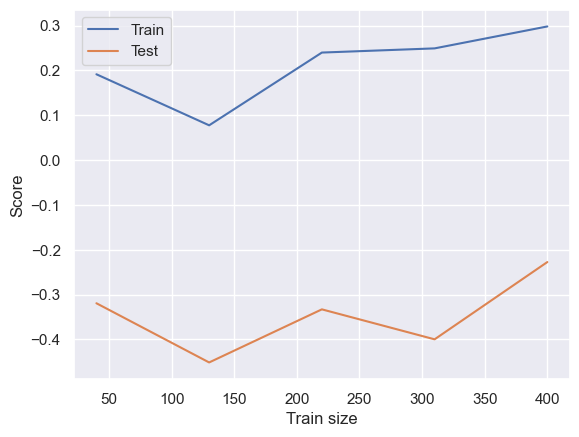

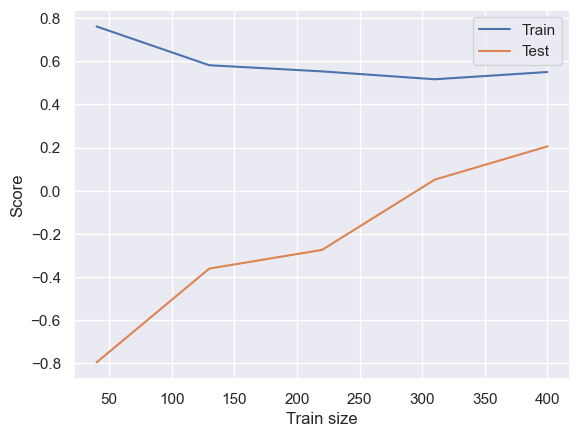

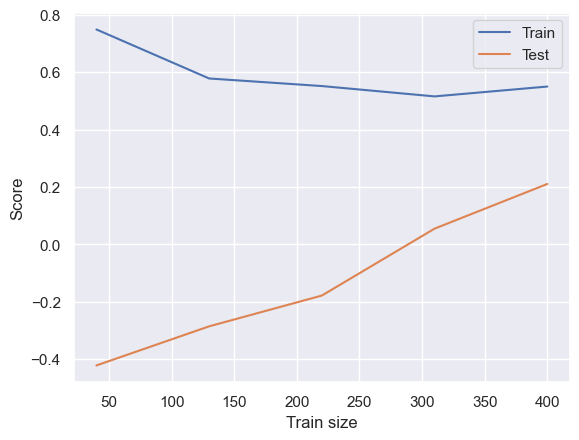

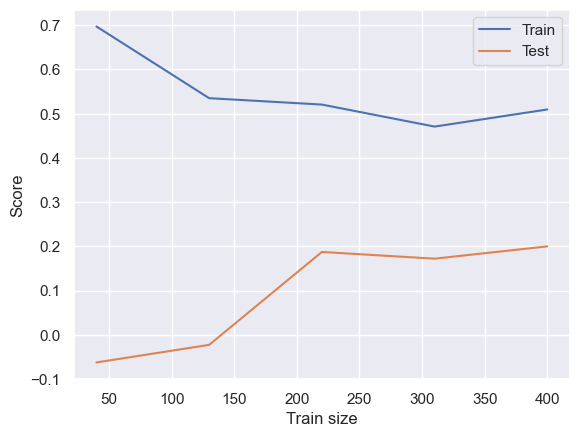

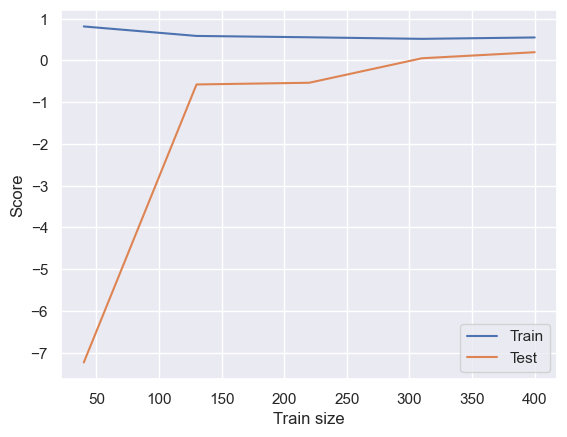

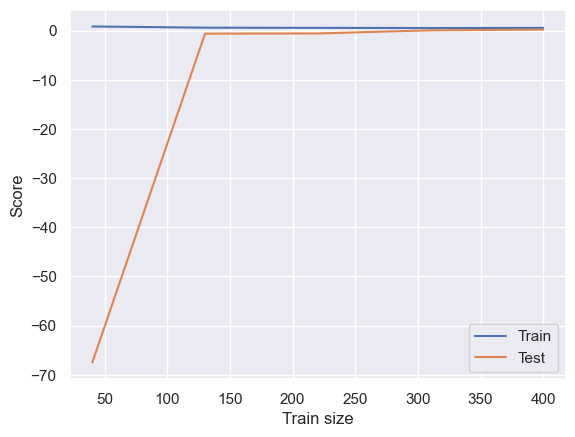

In [53]:
#learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, Y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=5)
    sns.set_theme()

    plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
    plt.plot(train_sizes, test_scores.mean(axis=1), label="Test")
    plt.xlabel("Train size")
    plt.ylabel("Score")

    plt.legend()
    plt.show()

for config in configs:
    plot_learning_curve(config, X, Y)
